# Causal Inference with CEM and Weighted Regression

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from cem import match
from cem import coarsen
from cem.imbalance import L1
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [3]:
uri = os.environ["MONGODB_URI"]
client = MongoClient(uri, server_api=ServerApi("1"))
client.admin.command("ping")
db = client["real-estate"]
collection = db["listings"]

In [4]:
since = datetime.now() - timedelta(days=30)

pipeline = [
        {
            "$match": {"rental": True, "datetime": {"$gte": since}, "bed": {"$lte": 4}},
        },
    ]

results = collection.aggregate(pipeline)

df = pd.DataFrame.from_records(results).set_index("_id")
df.head()

,datetime,provider,rental,price,address,suburb,state,postcode,council,bed,bath,parking,area,dwelling,version
_id,,,,,,,,,,,,,,,
listing-16678011,2023-09-30,domain,True,600,"Tennyson Avenue, Plympton Park, Adelaide, City...",plympton park,sa,5038,city of marion,3,1,2,NaN,house,0.1.0
listing-16677966,2023-09-30,domain,True,595,"Waikiki Court, West Lakes, Adelaide, City of C...",west lakes,sa,5021,city of charles sturt,3,1,2,NaN,house,0.1.0
listing-16675969,2023-09-30,domain,True,650,"Bimini Crescent, Mawson Lakes, Adelaide, City ...",mawson lakes,sa,5095,city of salisbury,3,2,1,NaN,townhouse,0.1.0
listing-16677999,2023-09-30,domain,True,480,"Pierson Street, Campbelltown City Council, Ade...",hectorville,sa,5073,city of campbelltown,3,1,2,NaN,house,0.1.0
listing-16677277,2023-09-30,domain,True,610,"Grote Street, Adelaide, Adelaide City Council,...",adelaide,sa,5000,corporation of the city of adelaide,2,1,0,NaN,apartment / unit / flat,0.1.0


In [5]:
df.describe()

,datetime,price,bed,bath,parking,area
count,403,403.000000,403.000000,403.000000,403.000000,49.000000
mean,2023-10-04 15:43:19.503721984,566.600496,2.784119,1.468983,1.694789,459.979592
min,2023-09-30 00:00:00,195.000000,1.000000,1.000000,0.000000,71.000000
25%,2023-09-30 00:00:00,460.000000,2.000000,1.000000,1.000000,320.000000
50%,2023-10-04 00:00:00,545.000000,3.000000,1.000000,2.000000,419.000000
75%,2023-10-09 00:00:00,620.000000,3.000000,2.000000,2.000000,637.000000
max,2023-10-10 00:00:00,1800.000000,4.000000,3.000000,8.000000,990.000000
std,NaN,184.366892,0.760038,0.551710,1.145464,216.709626


In [6]:
df[["bed", "bath", "parking"]].cov()

,bed,bath,parking
bed,0.577658,0.188561,0.404096
bath,0.188561,0.304384,0.113644
parking,0.404096,0.113644,1.312087


In [7]:
df["council"].value_counts()

council
city of port adelaide enfield                             42
city of playford                                          42
city of charles sturt                                     40
corporation of the city of adelaide                       33
city of salisbury                                         31
city of marion                                            29
corporation of the city of unley                          23
city of onkaparinga                                       22
city of norwood payneham & st peters                      20
city of west torrens                                      16
city of campbelltown                                      14
city of burnside                                          13
city of holdfast bay                                      13
city of tea tree gully                                    12
mount barker district council                             11
city of prospect & city of port adelaide enfield          11
city of mitcham 

In [8]:
councils = {
    "city of playford": "north",
    "city of port adelaide enfield": "north",
    "city of charles sturt": "west",
    "city of salisbury": "north",
    "corporation of the city of adelaide": "inner",
    "corporation of the city of unley": "inner",
    "city of marion": "south",
    "city of onkaparinga": "south",
    "city of campelltown": "east",
    "city of norwood payneham & st peters": "inner",
    "city of west torrens": "west",
    "city of tea tree gully": "north",
    "city of burnside": "east",
    "city of holdfast bay": "west",
    "mount barker district council": "hills",
    "city of prospect & city of port adelaide enfield": "north",
    "corporation of the town of walkerville": "inner",
    "city of mitcham": "south",
    "city of prospect": "inner",
    "adelaide hills council": "hills",
    "town of gawler": "outer",
    "the barossa council": "outer",
    "city of port adelaide enfield & city of tea tree gully": "north"
}

In [9]:
y = df["price"]
X = df.drop(columns="price")[["bed", "bath", "parking", "council", "dwelling"]]

In [10]:
# no matching
L1(X, "bed")
# very imbalanced

,bed_level_a,bed_level_b,imbalance
0,1,2,0.779227
1,1,3,0.995146
2,1,4,1.000000
3,2,3,0.835374
4,2,4,0.939130
5,3,4,0.779430


In [11]:
# exact matching
# throw away examples from strata (defined by council, dwelling, bath and parking) that do not contain all levels of the treatment (number of beds)
weights = match(X, "bed")

print(f"{(weights > 0).sum()} observations remain. Threw away {(weights == 0).sum()}")

L1(X, "bed", weights)
# no examples left..

0 observations remain. Threw away 403


/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/match.py:30: UserWarning: No strata had all levels of the treatment variable. All weights will be zero. This usually happens when a continuous variable (including the treatment variable) is not coarsened.
  warnings.warn(
/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2


,bed_level_a,bed_level_b,imbalance
0,1,2,NaN
1,1,3,NaN
2,1,4,NaN
3,2,3,NaN
4,2,4,NaN
5,3,4,NaN


In [12]:
# coarsened exact matching
# throw away examples from strata (defined by COARSENED council, dwelling, bath and parking) that do not contain all levels of the treatment (number of beds)
X_coarse = X.copy()

X_coarse["council"] = X_coarse["council"].map(councils)  # north, south, east, west, inner, hills, outer
X_coarse["parking"] = X_coarse["parking"] > 0  # yes or no
X_coarse["bath"] = pd.cut(X_coarse["bath"], bins=[-1, 1, 2, 100])  # 1, 2, 3+

weights = match(X_coarse, "bed")
weights = weights[X.index]  # not necessary, but it supresses that warning

print(f"{(weights > 0).sum()} observations remain. Threw away {(weights == 0).sum()}")

L1(X_coarse, "bed", weights)

59 observations remain. Threw away 344


,bed_level_a,bed_level_b,imbalance
0,1,2,5.551115e-17
1,1,3,5.551115e-17
2,1,4,0.000000e+00
3,2,3,0.000000e+00
4,2,4,5.551115e-17
5,3,4,5.551115e-17


In [13]:
X_coarse[weights > 0].sort_values(["council", "dwelling", "bath", "parking", "bed"]).head(20)

,bed,bath,parking,council,dwelling
_id,,,,,
listing-16669147,1,"(-1, 1]",True,inner,house
listing-15824497,1,"(-1, 1]",True,inner,house
listing-16323766,2,"(-1, 1]",True,inner,house
listing-15725312,2,"(-1, 1]",True,inner,house
listing-16677326,3,"(-1, 1]",True,inner,house
listing-16670501,3,"(-1, 1]",True,inner,house
listing-16680618,3,"(-1, 1]",True,inner,house
listing-16687722,3,"(-1, 1]",True,inner,house
listing-16689899,3,"(-1, 1]",True,inner,house


In [14]:
print(X_coarse[weights > 0]["dwelling"].value_counts())
print(X_coarse[weights > 0]["council"].value_counts())
print(X_coarse[weights > 0]["parking"].value_counts())
print(X_coarse[weights > 0]["bath"].value_counts())

dwelling
house    59
Name: count, dtype: int64
council
north    48
inner    11
Name: count, dtype: int64
parking
True    59
Name: count, dtype: int64
bath
(-1, 1]     59
(1, 2]       0
(2, 100]     0
Name: count, dtype: int64


In [15]:
# after coarsened matching, there is very little imbalance, so i'm happy not to control for council and dwelling
model = sm.WLS(y, sm.add_constant(X[["bed"]]), weights=weights, hasconst=True)
model.exog_names[:] = ["constant", "bed"]
results = model.fit()

In [16]:
summary = results.summary()
summary

/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.171
Model:                            WLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     82.78
Date:                Tue, 10 Oct 2023   Prob (F-statistic):           4.34e-18
Time:                        17:20:16   Log-Likelihood:                   -inf
No. Observations:                 403   AIC:                               inf
Df Residuals:                     401   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     275.8905     28.142      9.804      0.000     220.566     331.215
bed           87.1731      9.581      9.098      0.000      68.337     106.009
==============================================================================
Omnibus:                      478.793   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46650.800
Skew:                           5.348   Prob(JB):                         0.00
Kurtosis:                      54.612   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
print(summary.as_html())

<table class="simpletable">
<caption>WLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>          <td>price</td>      <th>  R-squared:         </th> <td>   0.171</td>
</tr>
<tr>
  <th>Model:</th>                   <td>WLS</td>       <th>  Adj. R-squared:    </th> <td>   0.169</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   82.78</td>
</tr>
<tr>
  <th>Date:</th>             <td>Tue, 10 Oct 2023</td> <th>  Prob (F-statistic):</th> <td>4.34e-18</td>
</tr>
<tr>
  <th>Time:</th>                 <td>17:20:16</td>     <th>  Log-Likelihood:    </th> <td>    -inf</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>   403</td>      <th>  AIC:               </th> <td>     inf</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>   401</td>      <th>  BIC:               </th> <td>     inf</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     1</td>      <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th

In [30]:
# analysis of residuals
residual = results.resid
predicted = results.fittedvalues

<Axes: xlabel='bed', ylabel='None'>

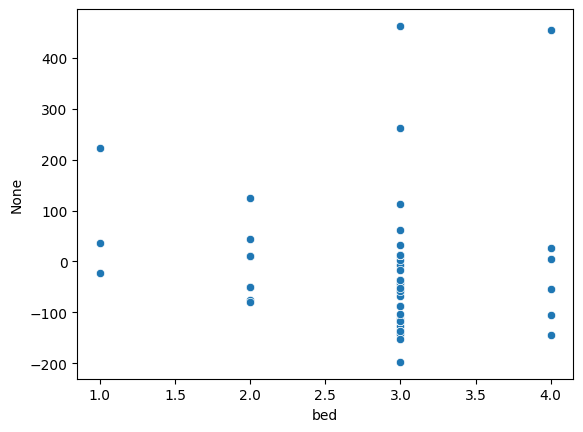

In [42]:
sns.scatterplot(x=X[weights > 0]['bed'], y=results.resid[weights > 0])

In [45]:
X[weights > 0][X["bed"] == 4]

/var/folders/ny/pj5f0n495_x0jds16s45pznc0000gn/T/ipykernel_78242/4009992164.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X[weights > 0][X["bed"] == 4]


,bed,bath,parking,council,dwelling,residual,predicted
_id,,,,,,,
listing-16671423,4,1,6,city of tea tree gully,house,25.417148,624.582852
listing-16677398,4,1,4,city of salisbury,house,-144.582852,624.582852
listing-16682898,4,1,3,corporation of the town of walkerville,house,-54.582852,624.582852
listing-16682726,4,1,2,city of prospect & city of port adelaide enfield,house,5.417148,624.582852
listing-16680648,4,1,2,corporation of the city of unley,house,455.417148,624.582852
listing-16647783,4,1,2,city of playford,house,-104.582852,624.582852


In [46]:
y[weights > 0][X["bed"] == 4]

_id
listing-16671423     650
listing-16677398     480
listing-16682898     570
listing-16682726     630
listing-16680648    1080
listing-16647783     520
Name: price, dtype: int64

In [ ]:
# possibly the ignorability assumption is not satisfied (i.e. area of that listing-16680648 is 800m2!)
# i.e. there are other confounders that should be taken into account